In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyRAPL

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# Setup pyRAPL for messuring energy and time
pyRAPL.setup()

lr_measure = pyRAPL.Measurement('Lin_Measurement')
lasso_measure = pyRAPL.Measurement('Lasso_Measurement')
ridge_measure = pyRAPL.Measurement('Ridge_Measurement')
elastic_measure = pyRAPL.Measurement('ElasticNet_Measurement')
knn_measure = pyRAPL.Measurement('KNN_Measurement')
svr_measure = pyRAPL.Measurement('SVR_Measurement')
pre_processing = pyRAPL.Measurement('Pre_Process')
pre_processing.begin()

In [4]:
# Load database
df = pd.read_csv('SeoulBikeData.csv', encoding = 'latin')
df.head()

,Date,Rented Bike Count,Hour,Temperature(ï¿½C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ï¿½C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
# Renaming Columns
df.rename(columns={'Date': 'date', 'Rented Bike Count': 'bike_count', 'Hour': 'hour',
                   'Temperature(ï¿½C)': 'temp', 'Humidity(%)': 'humidity', 'Wind speed (m/s)': 'wind',
                   'Visibility (10m)': 'visibility', 'Dew point temperature(ï¿½C)': 'dew_temp',
                   'Solar Radiation (MJ/m2)': 'sunlight', 'Rainfall(mm)': 'rain', 'Snowfall (cm)': 'snow',
                   'Seasons': 'season', 'Holiday': 'holiday', 'Functioning Day': 'functioning_day'}, inplace=True)
df.head()

,date,bike_count,hour,temp,humidity,wind,visibility,dew_temp,sunlight,rain,snow,season,holiday,functioning_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [6]:
# Check if there are missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             8760 non-null   object 
 1   bike_count       8760 non-null   int64  
 2   hour             8760 non-null   int64  
 3   temp             8760 non-null   float64
 4   humidity         8760 non-null   int64  
 5   wind             8760 non-null   float64
 6   visibility       8760 non-null   int64  
 7   dew_temp         8760 non-null   float64
 8   sunlight         8760 non-null   float64
 9   rain             8760 non-null   float64
 10  snow             8760 non-null   float64
 11  season           8760 non-null   object 
 12  holiday          8760 non-null   object 
 13  functioning_day  8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB


In [7]:
df.describe(percentiles=[.01,.25,.5,.75,.99]).transpose()

,count,mean,std,min,1%,25%,50%,75%,99%,max
bike_count,8760.0,704.602055,644.997468,0.0,0.000,191.00,504.50,1065.25,2526.23,3556.00
hour,8760.0,11.500000,6.922582,0.0,0.000,5.75,11.50,17.25,23.00,23.00
temp,8760.0,12.882922,11.944825,-17.8,-12.741,3.50,13.70,22.50,35.10,39.40
humidity,8760.0,58.226256,20.362413,0.0,17.000,42.00,57.00,74.00,97.00,98.00
wind,8760.0,1.724909,1.036300,0.0,0.100,0.90,1.50,2.30,4.70,7.40
visibility,8760.0,1436.825799,608.298712,27.0,173.000,940.00,1698.00,2000.00,2000.00,2000.00
dew_temp,8760.0,4.073813,13.060369,-30.6,-24.800,-4.70,5.10,14.80,24.70,27.20
sunlight,8760.0,0.569111,0.868746,0.0,0.000,0.00,0.01,0.93,3.17,3.52
rain,8760.0,0.148687,1.128193,0.0,0.000,0.00,0.00,0.00,4.00,35.00
snow,8760.0,0.075068,0.436746,0.0,0.000,0.00,0.00,0.00,2.50,8.80


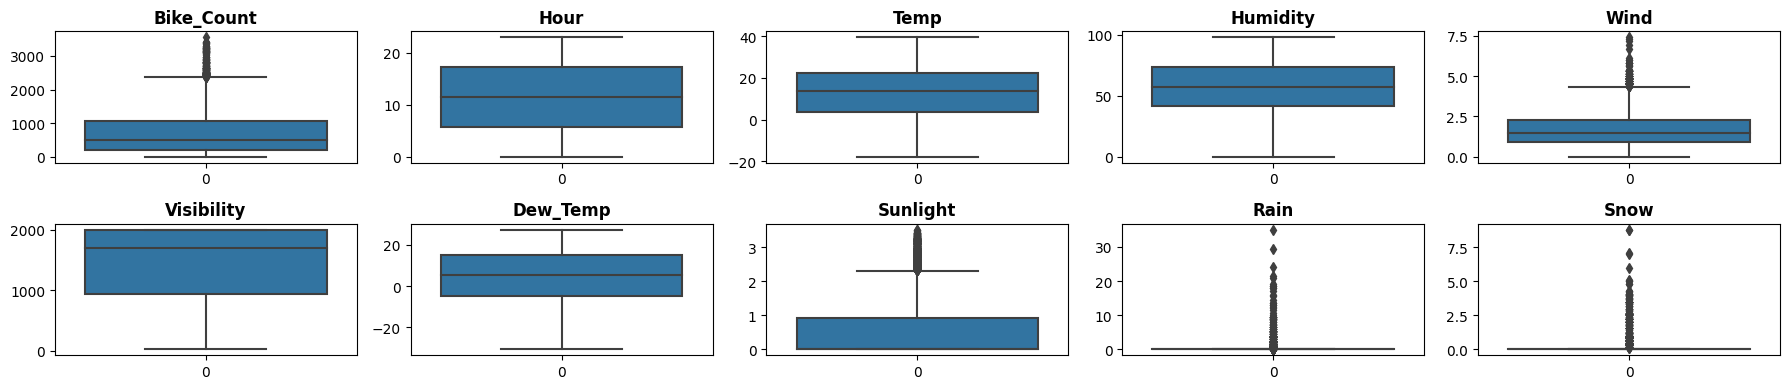

In [7]:
# Checking for outliers
plt.figure(figsize=(18,4))
for n,column in enumerate(df.describe().columns):
  plt.subplot(2, 5, n+1)
  sns.boxplot(df[column])
  plt.title(f'{column.title()}',weight='bold')
  plt.tight_layout()

In [8]:
# Removing outliers by Using IQR method:
q1, q3, median = df.bike_count.quantile([0.25,0.75,0.5])
lower_limit = q1 - 1.5*(q3-q1)
upper_limit = q3 + 1.5*(q3-q1)
df['bike_count'] = np.where(df['bike_count'] > upper_limit, median,np.where(
                            df['bike_count'] < lower_limit,median,df['bike_count']))

# Removing outliers by Capping:
for col in ['wind','sunlight','rain','snow']:
  upper_limit = df[col].quantile(0.99)
  df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])

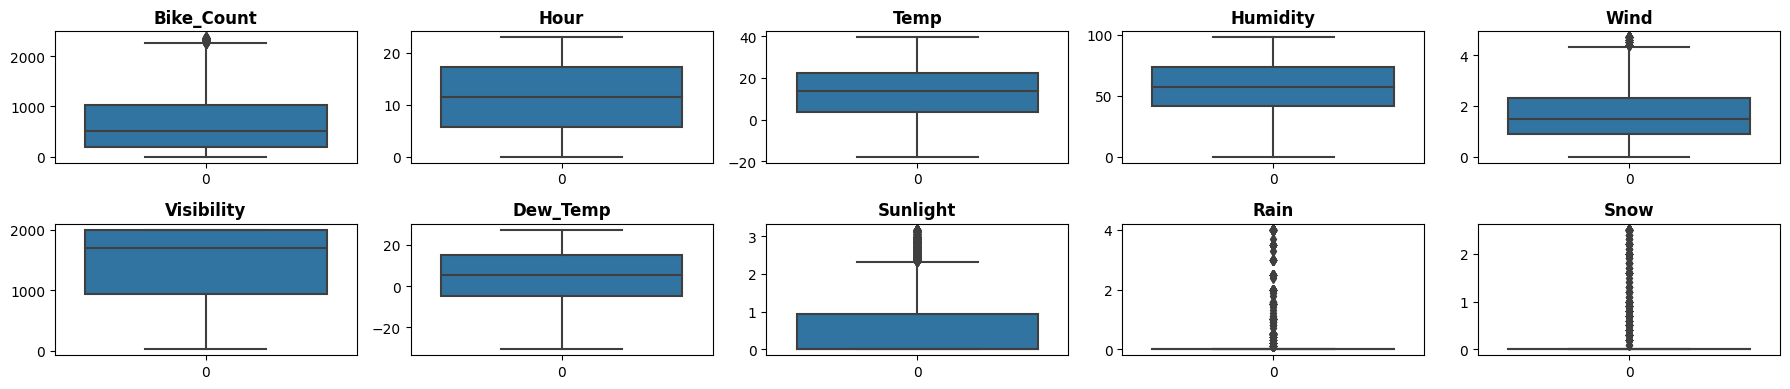

In [9]:
# Checking for outliers
plt.figure(figsize=(18,4))
for n,column in enumerate(df.describe().columns):
  plt.subplot(2, 5, n+1)
  sns.boxplot(df[column])
  plt.title(f'{column.title()}',weight='bold')
  plt.tight_layout()

In [9]:
df['date']=df['date'].astype('datetime64[ns]')

/tmp/ipykernel_22510/3354169194.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date']=df['date'].astype('datetime64[ns]')


In [10]:
df['day']=df['date'].dt.day_name()

In [11]:
# Creating new column and Encoding with 1 if its weekend and 0 if its Weekdays. 
# And Creating new column and Enconding it based on the hour of the day
df['weekdays_or_weekend']=df['day'].apply(lambda x: 1 if x=='Saturday' or x=='Sunday' else 0)
df['timeshift'] = df['hour'].apply(lambda x: 'night' if 0<=x<=6 else ('day' if 7<=x<=16 else 'evening'))

In [12]:
# Dropping the Date, day, hour columns
df.drop(columns=['date','day','hour'], inplace = True)

In [13]:
# checkong for categorical features
categorical_features = [i for i in df.columns if i not in df.describe().columns]
categorical_features

['season', 'holiday', 'functioning_day', 'timeshift']

In [14]:
# Defining a label encoder based on above data
encoder = {'holiday':{'Holiday':1, 'No Holiday':0},'functioning_day':{'Yes':1, 'No': 0},
          'timeshift': {'night':0, 'day':1, 'evening':2}}

In [15]:
df = df.replace(encoder)

# making new columns for every season
df = pd.get_dummies(df, columns=["season"], prefix='', prefix_sep='')

In [16]:
# Putting target data to the end column of database
independent_variables = [i for i in df.columns if i not in ['bike_count']]
df = df[independent_variables + ['bike_count']]

In [17]:
# New look
df.head()

,temp,humidity,wind,visibility,dew_temp,sunlight,rain,snow,holiday,functioning_day,weekdays_or_weekend,timeshift,Autumn,Spring,Summer,Winter,bike_count
0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,1,0,0,0,0,0,1,254.0
1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,1,0,0,0,0,0,1,204.0
2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,1,0,0,0,0,0,1,173.0
3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,1,0,0,0,0,0,1,107.0
4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,1,0,0,0,0,0,1,78.0


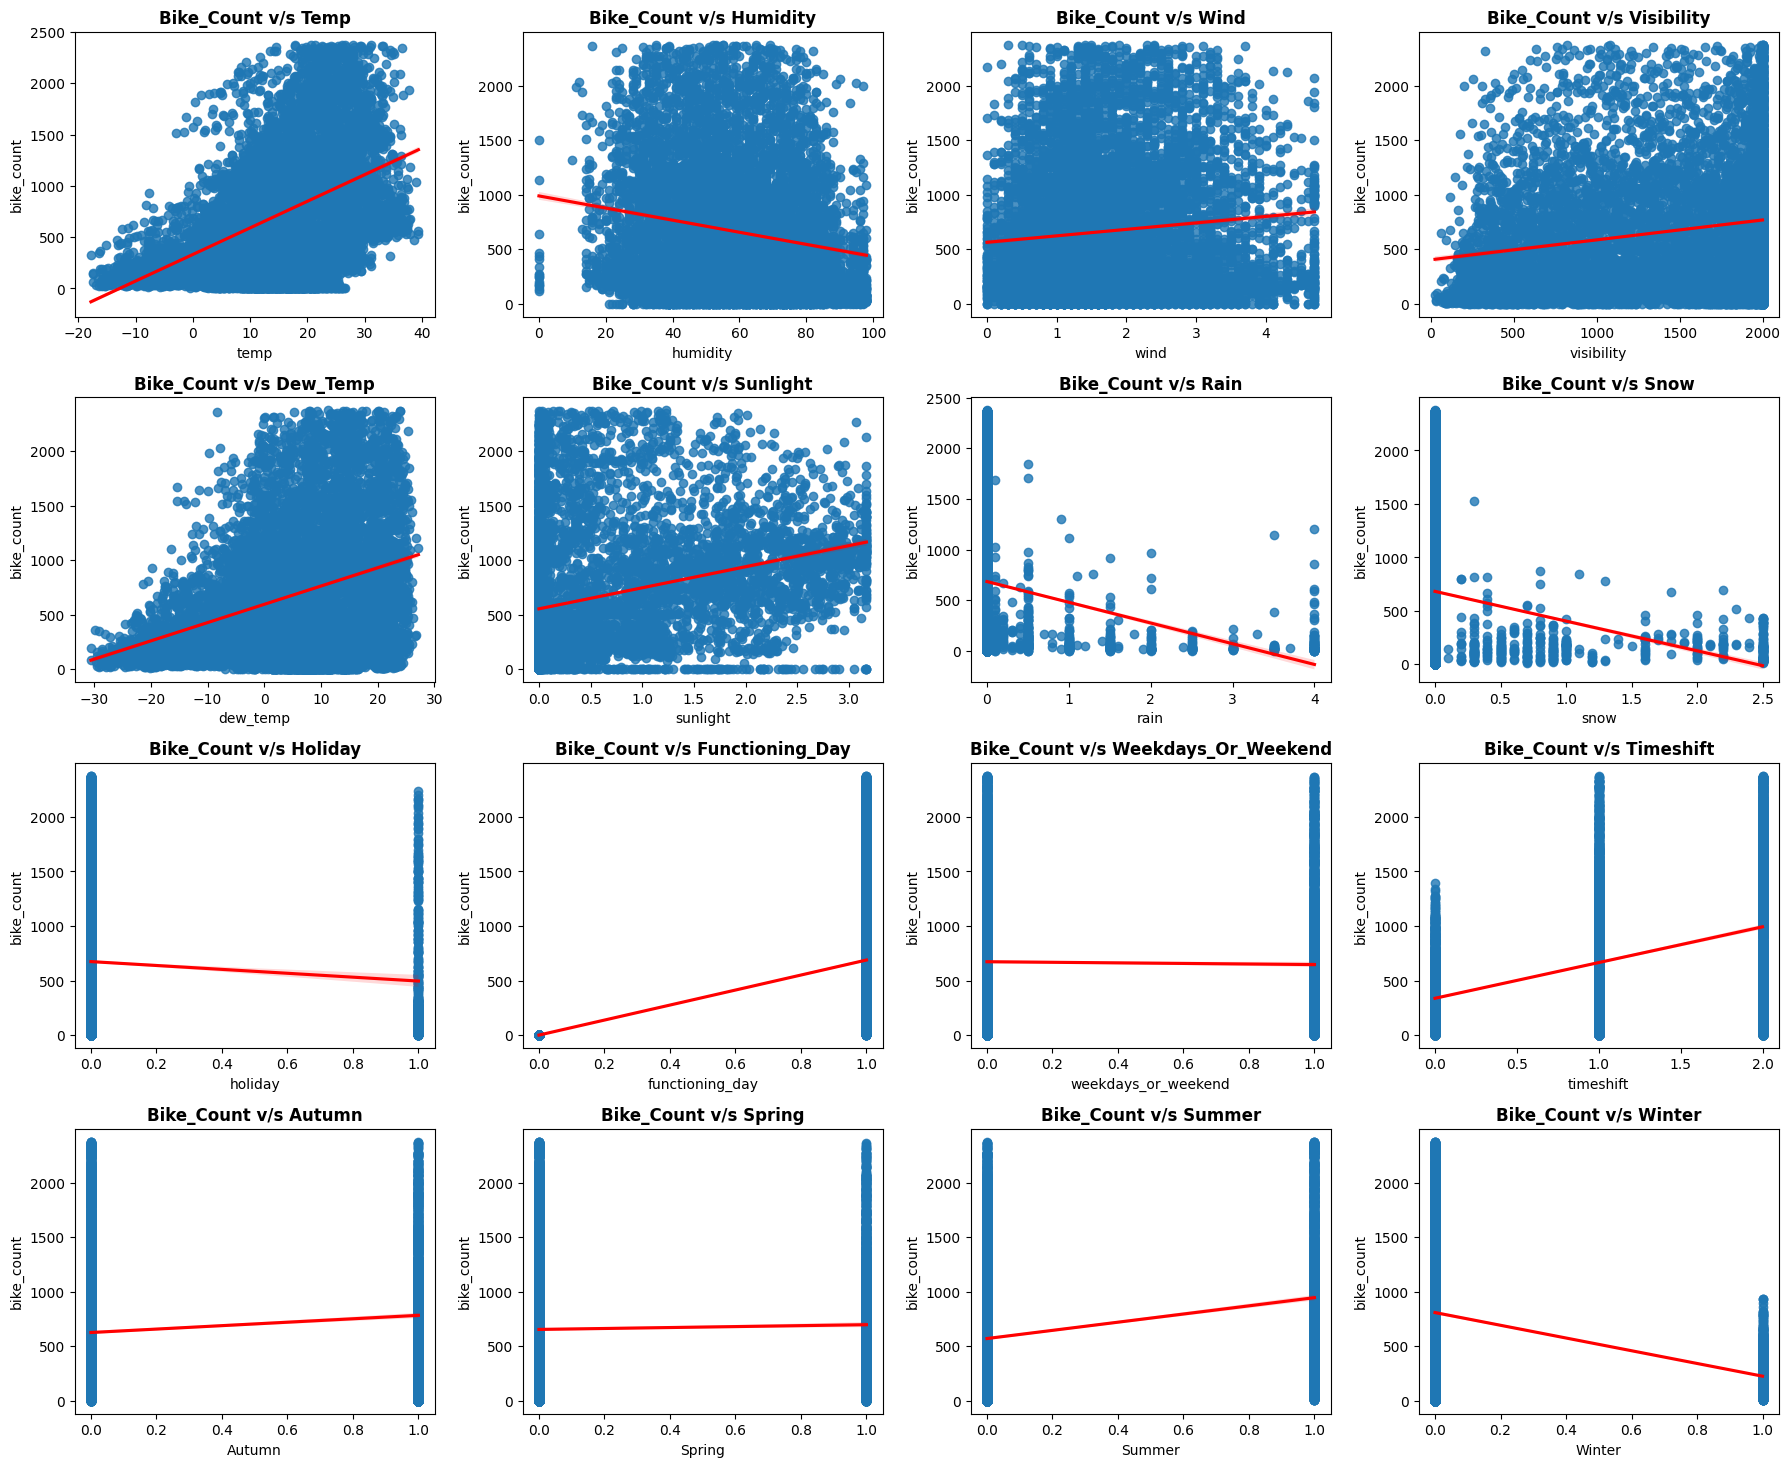

In [19]:
independent_variables = [i for i in df.columns if i not in ['bike_count']]

# Checking Linearity
plt.figure(figsize=(18,18))
for n,column in enumerate(independent_variables):
  plt.subplot(5, 4, n+1)
  sns.regplot(data = df, x = column, y ='bike_count',line_kws={"color": "red"})
  plt.title(f'Bike_Count v/s {column.title()}',weight='bold')
  plt.tight_layout()

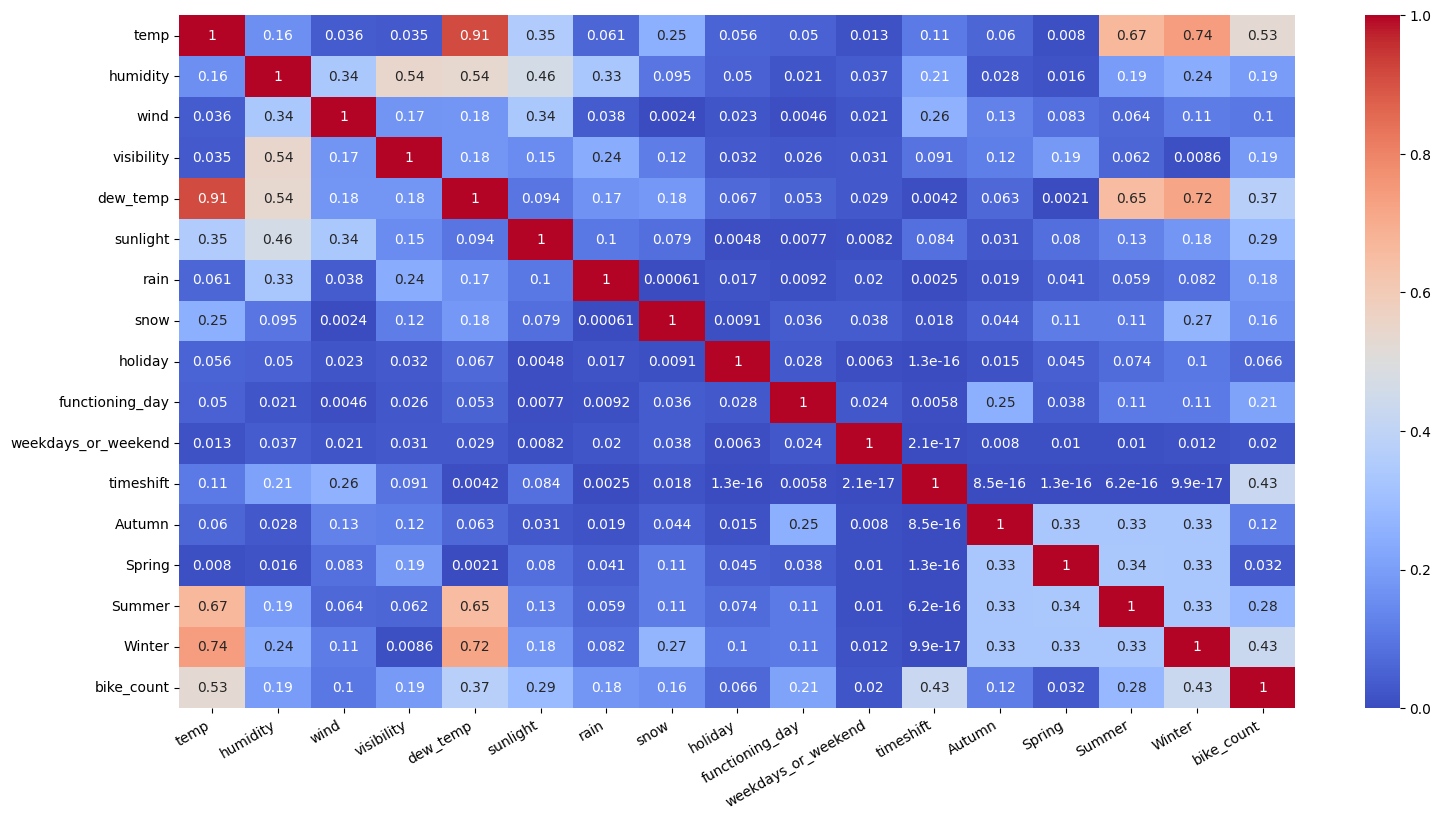

In [20]:
# Checking corelations
plt.figure(figsize=(18,9))
plot=sns.heatmap(abs(df.corr()), annot=True, cmap='coolwarm')
plot.set_xticklabels(plot.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [19]:
df.drop(columns=['dew_temp', 'Summer', 'Winter'],inplace=True)  

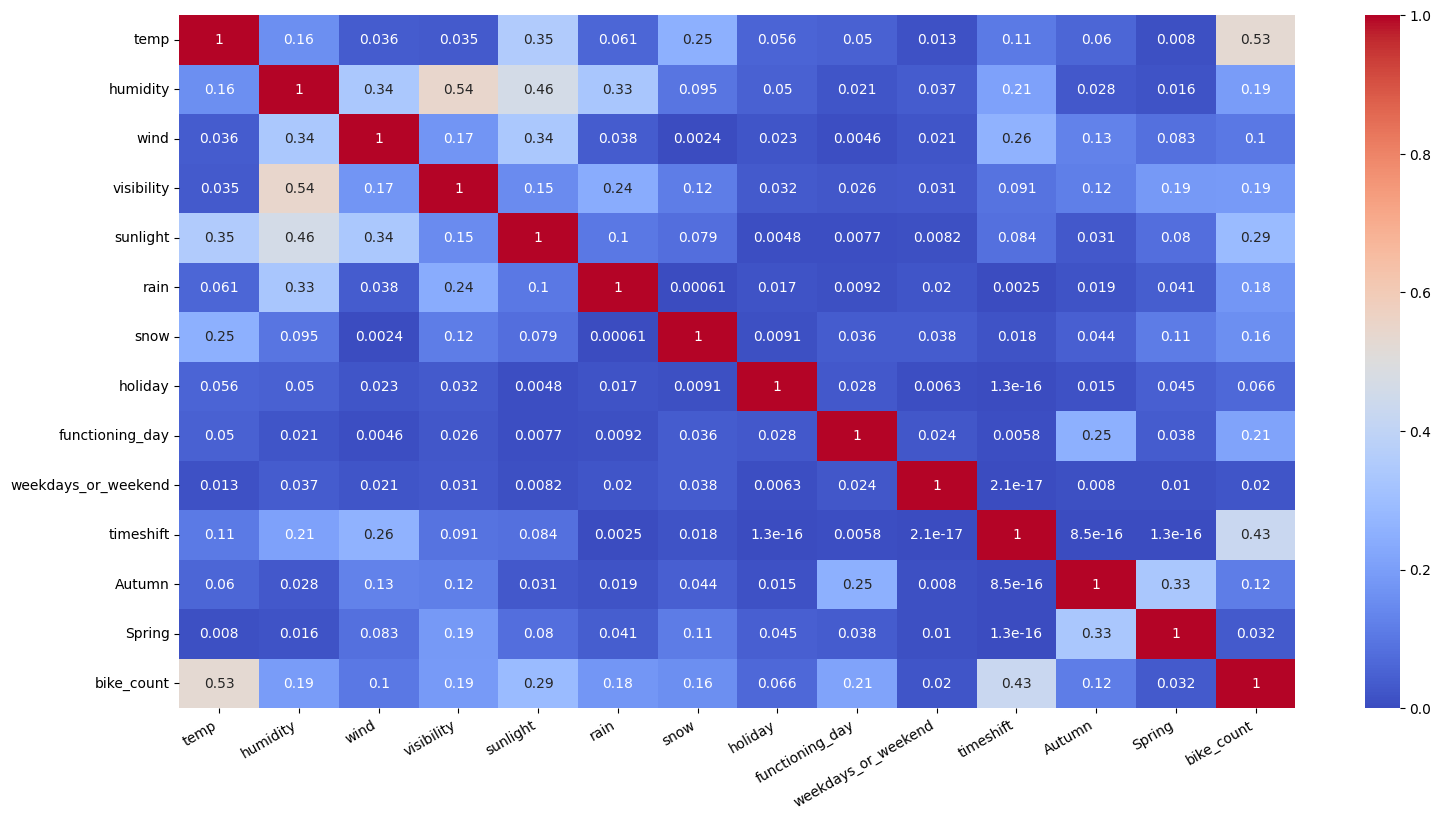

In [22]:
# Checking corelations
plt.figure(figsize=(18,9))
plot=sns.heatmap(abs(df.corr()), annot=True, cmap='coolwarm')
plot.set_xticklabels(plot.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

**Skewness** is a measure of the asymmetry of a distribution. A distribution is asymmetrical when its left and right side are not mirror images.

**Right skew** is also referred to as positive skew.

**Left skew** is also referred to as negative skew.

In [23]:
# Checking skewness of the dependend variable
print(f'Skewness of original data : {df.bike_count.skew()}')
print(f'Skewness after log transformation : {np.log1p(df.bike_count).skew()}')
print(f'Skewness after sqrt transformation : {np.sqrt(df.bike_count).skew()}')
print(f'Skewness after cbrt transformation : {np.cbrt(df.bike_count).skew()}')

Skewness of original data : 0.983470199089409
Skewness after log transformation : -1.8949997547915536
Skewness after sqrt transformation : 0.153123685071092
Skewness after cbrt transformation : -0.39806233492612664


<Figure size 400x900 with 0 Axes>

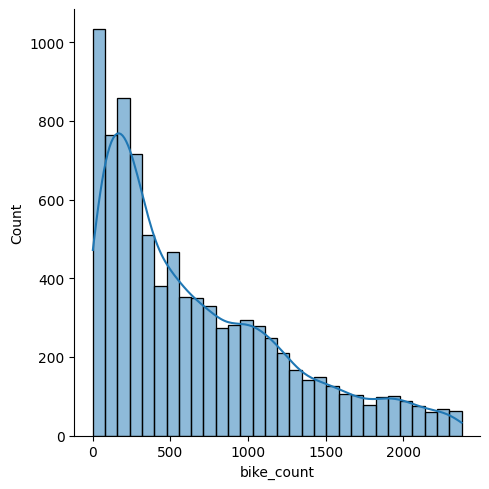

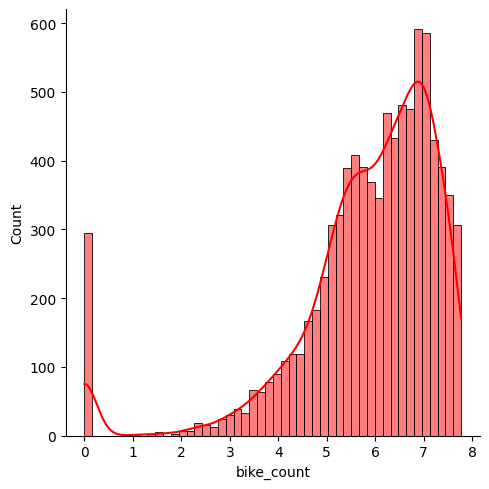

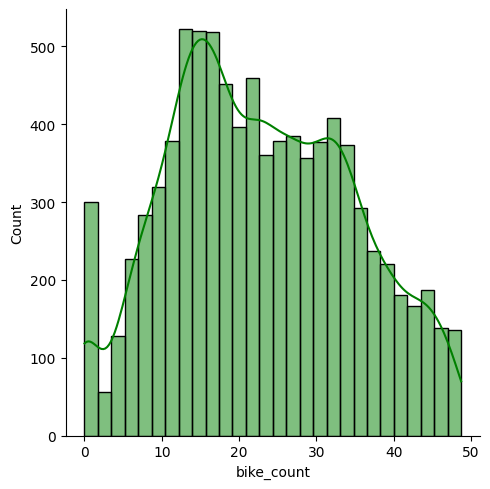

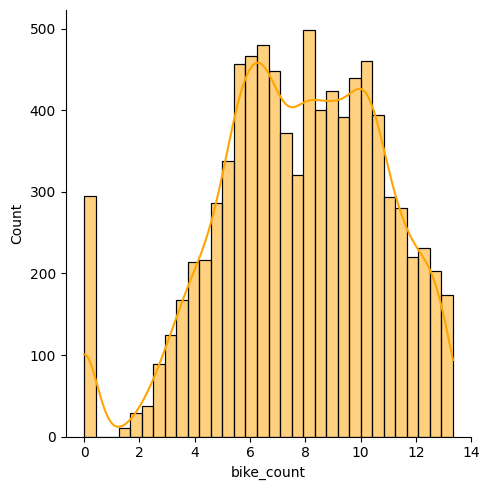

In [24]:
# Since Sqrt Transformation gives skewness between -0.5 and 0.5 indicates that 
# the distribution is fairly symmetrical we will use it

plt.figure(figsize=(4,9))

sns.displot(df, x="bike_count", kde=True)

sns.displot(np.log1p(df['bike_count']), kde=True, color="red")

sns.displot(np.sqrt(df['bike_count']), kde=True, color="green")

sns.displot(np.cbrt(df['bike_count']), kde=True, color="orange")

plt.tight_layout()

In [20]:
#Pre-processing values
pre_processing.end()
pre_processing.result

Result(label='Pre_Process', timestamp=1674166111.0212805, duration=33506165.847, pkg=[685414322.0], dram=[36058502.0])

In [71]:
# Defining testing and target data
scaler = MinMaxScaler()
X = scaler.fit_transform(df.iloc[:, 0:12])
y = np.sqrt(df['bike_count'])

In [72]:
def predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    a,p = y_test**2,y_pred**2

    mae = mean_absolute_error(a,p)
    mse = mean_squared_error(a,p)
    rmse = np.sqrt(mse)
    train_r2 = r2_score(y_train**2,model.predict(X_train)**2)
    test_r2 = r2_score(a,p)
    adj_r2 = 1-(1-test_r2)*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))

    global mae_model 
    global mse_model 
    global rmse_model 
    global adj_r2_model 
    global y_pred_model

    mae_model.append(mae)
    mse_model.append(mse)
    rmse_model.append(rmse) 
    adj_r2_model.append(adj_r2)
    y_pred_model.append(y_pred)

   

In [73]:
def get_score(model, X_train, X_test, y_train, y_test): 
    model.fit(X_train, y_train)
    predictions(model, X_test, y_test)
    return model.score(X_test, y_test)

In [74]:
# Using cross validation for calculationg scores
n_splits=5
folds = KFold(n_splits, shuffle=True)

scores_linear = []
scores_lasso = []
scores_ridge = []
scores_elastic = []
scores_knn = []
scores_svr = []

mae_model = []
mse_model = []
rmse_model = []
adj_r2_model = []
y_pred_model= []

lr_measure_model = []
lasso_measure_model = []
ridge_measure_model = []
elastic_measure_model = []
knn_measure_model = []
svr_measure_model = []

for n_times in range(2):
    for train_index, test_index in folds.split(X,y):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

        lr_measure.begin()
        scores_linear.append(get_score(LinearRegression(), X_train, X_test, y_train, y_test))  
        lr_measure.end()
        lr_measure_model.append(lr_measure.result)

        lasso_measure.begin()
        scores_lasso.append(get_score(Lasso(), X_train, X_test, y_train, y_test))
        lasso_measure.end()
        lasso_measure_model.append(lasso_measure.result)

        ridge_measure.begin()
        scores_ridge.append(get_score(Ridge(), X_train, X_test, y_train, y_test))
        ridge_measure.end()
        ridge_measure_model.append(ridge_measure.result)

        elastic_measure.begin()
        scores_elastic.append(get_score(ElasticNet(), X_train, X_test, y_train, y_test))
        elastic_measure.end()
        elastic_measure_model.append(elastic_measure.result)

        knn_measure.begin()
        scores_knn.append(get_score(KNeighborsRegressor(n_neighbors=7), X_train, X_test, y_train, y_test))
        knn_measure.end()
        knn_measure_model.append(knn_measure.result)

        svr_measure.begin()
        scores_svr.append(get_score(SVR(kernel='rbf'), X_train, X_test, y_train, y_test))
        svr_measure.end()
        svr_measure_model.append(svr_measure.result)

In [75]:
# Define a function to plot scatter plot for y_test and y_actual.
# To check how close we are to regresson line
def plot_scatter(y_pred,y_test):
  plt.figure(figsize=(16,5))
  sns.regplot(x=y_test,y=y_pred,scatter_kws={'color':'magenta'},line_kws={'color':'black'})
  plt.xlabel('Actual')
  plt.ylabel("Predicted")
  plt.title("Actual v/s Predicted")

**R2** assumes that every single variable explains the variation in the dependent variable.

**The adjusted R2** tells you the percentage of variation explained by only the independent variables that actually affect the dependent variable.

**Mean absolute Error (MAE)** is the sum od absolute diffrences between actual and predicted values. it doesn't consider the direction, that is, posituve or negative. Value closer to 0 is better.

**Mean Squared Error (MSE)** is a risk function that allows us to calculate the average squared difference between a feature’s or variable’s predicted and actual value. Value closer to 0 is better.

**Root Mean Squared Error (RMSE)** is an abbreviation for Root Mean Square Error, which is the square root of the value obtained from the Mean Square Error function. Value closer to 0 is better, but 0 is never achived.


In [76]:
#len(mae_model)
n = 0
pkg = []
dram = []

while(n < n_splits*2):
    pkg.append(lr_measure_model[n].pkg)
    pkg.append(lasso_measure_model[n].pkg)
    pkg.append(ridge_measure_model[n].pkg)
    pkg.append(elastic_measure_model[n].pkg)
    pkg.append(knn_measure_model[n].pkg)
    pkg.append(svr_measure_model[n].pkg)
    
    dram.append(lr_measure_model[n].dram)
    dram.append(lasso_measure_model[n].dram)
    dram.append(ridge_measure_model[n].dram)
    dram.append(elastic_measure_model[n].dram)
    dram.append(knn_measure_model[n].dram)
    dram.append(svr_measure_model[n].dram)
    n+=1
    
pkg_list = [item for sublist in pkg for item in sublist]
dram_list = [item for sublist in dram for item in sublist]


MAE: 259.4417515373433
MSE: 143868.89124735937
RMSE: 379.19874260102085
Adjusted R2: 0.5758788691397069
Algorithm duration: 0.011417544
Algorithm power usage: 0.6771956
Dram usage: 13263.1
Score: 67.02152657195981


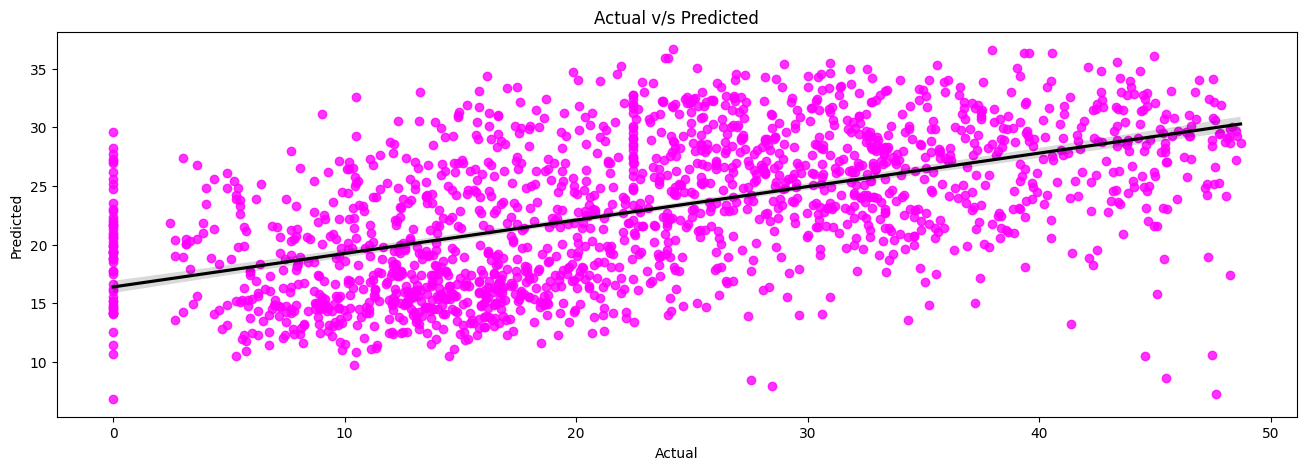

In [77]:
i = 0
j = 0
mae_linear = 0
mse_linear = 0
rmse_linear = 0
adj_r2_linear = 0
y_pred_linear = 0
duration_linear = 0
pkg_linear = 0
dram_linear = 0
score_linear_avr = 0

while(i < len(mae_model)):
    mae_linear += mae_model[i]
    mse_linear += mse_model[i]
    rmse_linear += rmse_model[i]
    adj_r2_linear += adj_r2_model[i]
    y_pred_linear += y_pred_model[i]
    duration_linear += lr_measure_model[j].duration
    pkg_linear += pkg_list[i]
    dram_linear += dram_list[i]
    score_linear_avr += scores_linear[j]
    i+=6
    j+=1
    
mae_linear /= n_splits * 2
mse_linear /= n_splits * 2
rmse_linear /= n_splits * 2
adj_r2_linear /= n_splits * 2
y_pred_linear /= n_splits * 2
duration_linear /= n_splits * 2
pkg_linear /= n_splits * 2
dram_linear /= n_splits * 2

score_linear_avr /= n_splits * 2
score_linear_avr *= 100

duration_linear /= 1000000
pkg_linear /= 1000000

print("MAE:", mae_linear)
print("MSE:", mse_linear)
print("RMSE:", rmse_linear)
print("Adjusted R2:", adj_r2_linear)
print("Algorithm duration:", duration_linear)
print("Algorithm power usage:", pkg_linear)
print("Dram usage:", dram_linear)
print("Score:", score_linear_avr)
plot_scatter(y_pred_linear,y_test)

MAE: 408.7744441066642
MSE: 291009.1561735175
RMSE: 539.3676740133409
Adjusted R2: 0.14227858971516372
Algorithm duration: 0.038849953400000005
Algorithm power usage: 2.6702385
Dram usage: 39642.1
Score: 20.341606621954913


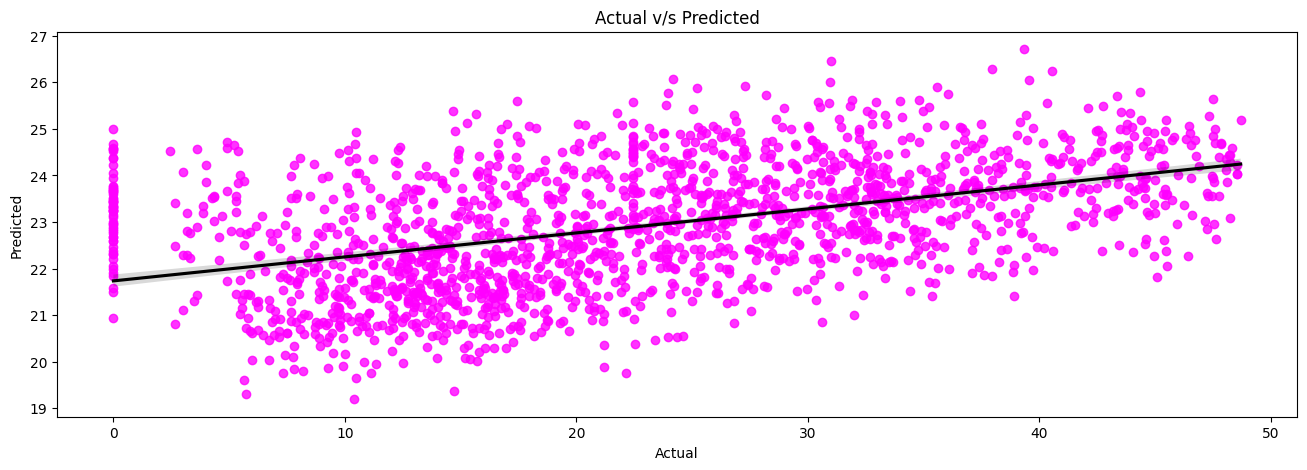

In [78]:
i = 1
j = 0
mae_lasso = 0
mse_lasso = 0
rmse_lasso = 0
adj_r2_lasso = 0
y_pred_lasso = 0
duration_lasso = 0
pkg_lasso = 0
dram_lasso = 0
score_lasso_avr = 0

while(i < len(mae_model)):
    mae_lasso += mae_model[i]
    mse_lasso += mse_model[i]
    rmse_lasso += rmse_model[i]
    adj_r2_lasso += adj_r2_model[i]
    y_pred_lasso += y_pred_model[i]
    duration_lasso += lasso_measure_model[j].duration
    pkg_lasso += pkg_list[i]
    dram_lasso+= dram_list[i]
    score_lasso_avr += scores_lasso[j] 
    i+=6
    j+=1
    
mae_lasso /= n_splits * 2
mse_lasso /= n_splits * 2
rmse_lasso/= n_splits * 2
adj_r2_lasso /= n_splits * 2
y_pred_lasso /= n_splits * 2
duration_lasso /= n_splits * 2
pkg_lasso /= n_splits * 2
dram_lasso /= n_splits * 2
score_lasso_avr /= n_splits * 2
score_lasso_avr *= 100

duration_lasso /= 1000000
pkg_lasso /= 1000000

print("MAE:", mae_lasso)
print("MSE:", mse_lasso)
print("RMSE:", rmse_lasso)
print("Adjusted R2:", adj_r2_lasso)
print("Algorithm duration:", duration_lasso)
print("Algorithm power usage:", pkg_lasso)
print("Dram usage:", dram_lasso)
print("Score:", score_lasso_avr)
plot_scatter(y_pred_lasso,y_test)

MAE: 259.6059804090602
MSE: 144017.19271568683
RMSE: 379.395034957668
Adjusted R2: 0.5754430385717867
Algorithm duration: 0.009867952300000002
Algorithm power usage: 0.6967693
Dram usage: 10522.5
Score: 67.02097340744166


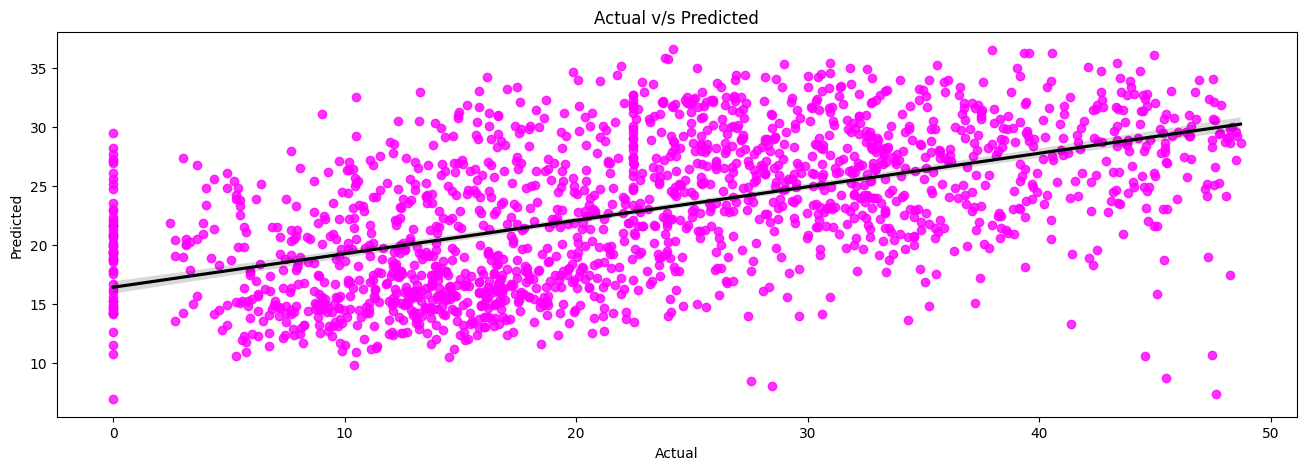

In [79]:
i = 2
j = 0
mae_ridge = 0
mse_ridge = 0
rmse_ridge = 0
adj_r2_ridge = 0
y_pred_ridge = 0
duration_ridge = 0
pkg_ridge = 0
dram_ridge = 0
score_ridge_avr = 0

while(i < len(mae_model)):
    mae_ridge += mae_model[i]
    mse_ridge += mse_model[i]
    rmse_ridge += rmse_model[i]
    adj_r2_ridge += adj_r2_model[i]
    y_pred_ridge += y_pred_model[i]
    duration_ridge += ridge_measure_model[j].duration
    pkg_ridge += pkg_list[i]
    dram_ridge += dram_list[i]
    score_ridge_avr += scores_ridge[j]
    i+=6
    j+=1
    
mae_ridge /= n_splits * 2
mse_ridge /= n_splits * 2
rmse_ridge /= n_splits * 2
adj_r2_ridge /= n_splits * 2
y_pred_ridge /= n_splits * 2
duration_ridge /= n_splits * 2
pkg_ridge /= n_splits * 2
dram_ridge /= n_splits * 2
score_ridge_avr /= n_splits * 2
score_ridge_avr *= 100

duration_ridge /= 1000000
pkg_ridge /= 1000000

print("MAE:", mae_ridge)
print("MSE:", mse_ridge)
print("RMSE:", rmse_ridge)
print("Adjusted R2:", adj_r2_ridge)
print("Algorithm duration:", duration_ridge)
print("Algorithm power usage:", pkg_ridge)
print("Dram usage:", dram_ridge)
print("Score:", score_ridge_avr)
plot_scatter(y_pred_ridge,y_test)

MAE: 439.4385292776572
MSE: 331440.57773776597
RMSE: 575.6263524406438
Adjusted R2: 0.02308983667203244
Algorithm duration: 0.015403404800000001
Algorithm power usage: 1.0884433999999998
Dram usage: 16503.8
Score: 9.313895330458825


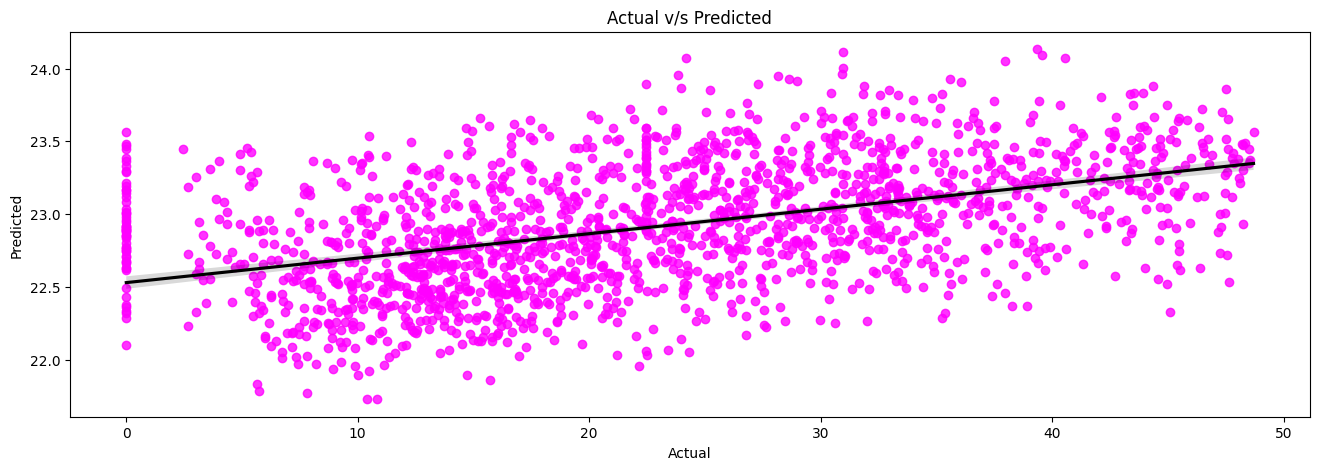

In [80]:
i = 3
j = 0
mae_elastic = 0
mse_elastic = 0
rmse_elastic = 0
adj_r2_elastic = 0
y_pred_elastic = 0
duration_elastic= 0
pkg_elastic = 0
dram_elastic = 0
score_elastic_avr = 0

while(i < len(mae_model)):
    mae_elastic += mae_model[i]
    mse_elastic += mse_model[i]
    rmse_elastic += rmse_model[i]
    adj_r2_elastic += adj_r2_model[i]
    y_pred_elastic += y_pred_model[i]
    duration_elastic += elastic_measure_model[j].duration
    pkg_elastic += pkg_list[i]
    dram_elastic += dram_list[i]
    score_elastic_avr += scores_elastic[j]
    i+=6
    j+=1
    
mae_elastic /= n_splits * 2
mse_elastic /= n_splits * 2
rmse_elastic /= n_splits * 2
adj_r2_elastic /= n_splits * 2
y_pred_elastic /= n_splits * 2
duration_elastic /= n_splits * 2
pkg_elastic /= n_splits * 2
dram_elastic /= n_splits * 2
score_elastic_avr /= n_splits * 2
score_elastic_avr *= 100

duration_elastic /= 1000000
pkg_elastic /= 1000000

print("MAE:", mae_elastic)
print("MSE:", mse_elastic)
print("RMSE:", rmse_elastic)
print("Adjusted R2:", adj_r2_elastic)
print("Algorithm duration:", duration_elastic)
print("Algorithm power usage:", pkg_elastic)
print("Dram usage:", dram_elastic)
print("Score:", score_elastic_avr)
plot_scatter(y_pred_elastic,y_test)

MAE: 211.85622695717794
MSE: 105742.28992556513
RMSE: 325.05972372586064
Adjusted R2: 0.6882569313826037
Algorithm duration: 0.3692971705
Algorithm power usage: 17.112944600000002
Dram usage: 362700.4
Score: 76.44379871981232


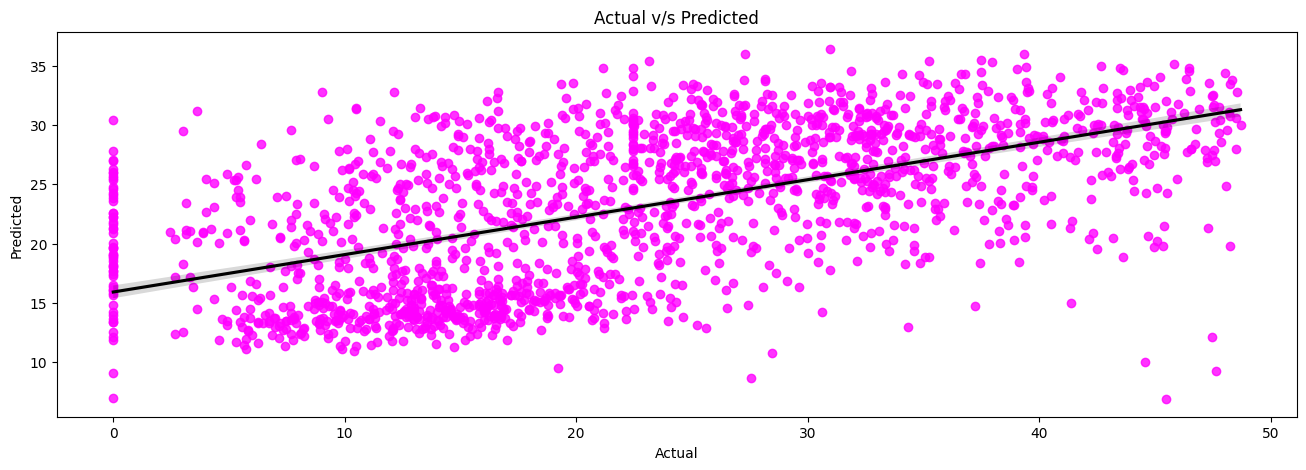

In [81]:
i = 4
j = 0
mae_knn = 0
mse_knn = 0
rmse_knn = 0
adj_r2_knn = 0
y_pred_knn = 0
duration_knn= 0
pkg_knn = 0
dram_knn = 0
score_knn_avr = 0

while(i < len(mae_model)):
    mae_knn += mae_model[i]
    mse_knn += mse_model[i]
    rmse_knn += rmse_model[i]
    adj_r2_knn += adj_r2_model[i]
    y_pred_knn += y_pred_model[i]
    duration_knn += knn_measure_model[j].duration
    pkg_knn += pkg_list[i]
    dram_knn += dram_list[i]
    score_knn_avr += scores_knn[j]
    i+=6
    j+=1
    
mae_knn /= n_splits * 2
mse_knn /= n_splits * 2
rmse_knn /= n_splits * 2
adj_r2_knn /= n_splits * 2
y_pred_knn /= n_splits * 2
duration_knn /= n_splits * 2
pkg_knn /= n_splits * 2
dram_knn /= n_splits * 2
score_knn_avr /= n_splits * 2
score_knn_avr *= 100

duration_knn /= 1000000
pkg_knn /= 1000000

print("MAE:", mae_knn)
print("MSE:", mse_knn)
print("RMSE:", rmse_knn)
print("Adjusted R2:", adj_r2_knn)
print("Algorithm duration:", duration_knn)
print("Algorithm power usage:", pkg_knn)
print("Dram usage:", dram_knn)
print("Score:", score_knn_avr)
plot_scatter(y_pred_knn,y_test)

MAE: 233.24040279022216
MSE: 125870.5241862603
RMSE: 354.6343907284942
Adjusted R2: 0.6288788145044765
Algorithm duration: 4.751019845199999
Algorithm power usage: 202.1647106
Dram usage: 4693170.5
Score: 72.8320258722488


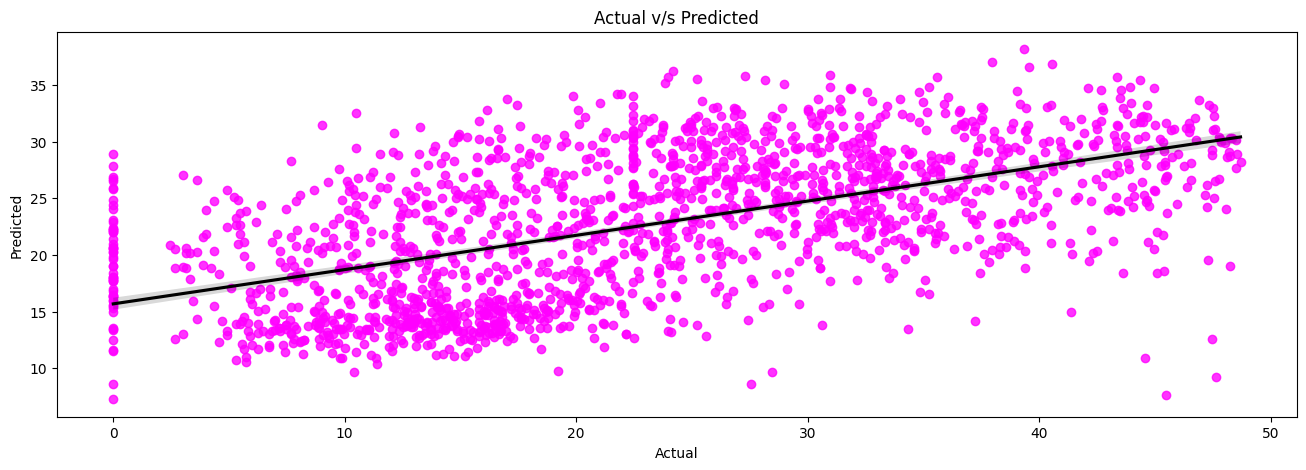

In [82]:
i = 5
j = 0
mae_svr = 0
mse_svr = 0
rmse_svr = 0
adj_r2_svr = 0
y_pred_svr = 0
duration_svr = 0
pkg_svr = 0
dram_svr = 0
score_svr_avr = 0

while(i < len(mae_model)):
    mae_svr += mae_model[i]
    mse_svr += mse_model[i]
    rmse_svr += rmse_model[i]
    adj_r2_svr += adj_r2_model[i]
    y_pred_svr += y_pred_model[i]
    duration_svr += svr_measure_model[j].duration
    pkg_svr += pkg_list[i]
    dram_svr += dram_list[i]
    score_svr_avr += scores_svr[j]
    i+=6
    j+=1
    
mae_svr /= n_splits * 2
mse_svr /= n_splits * 2
rmse_svr /= n_splits * 2
adj_r2_svr /= n_splits * 2
y_pred_svr /= n_splits * 2
duration_svr /= n_splits * 2
pkg_svr /= n_splits * 2
dram_svr /= n_splits * 2
score_svr_avr /= n_splits * 2
score_svr_avr *= 100

duration_svr /= 1000000
pkg_svr /= 1000000

print("MAE:", mae_svr)
print("MSE:", mse_svr)
print("RMSE:", rmse_svr)
print("Adjusted R2:", adj_r2_svr)
print("Algorithm duration:", duration_svr)
print("Algorithm power usage:", pkg_svr)
print("Dram usage:", dram_svr)
print("Score:", score_svr_avr)

plot_scatter(y_pred_svr,y_test)

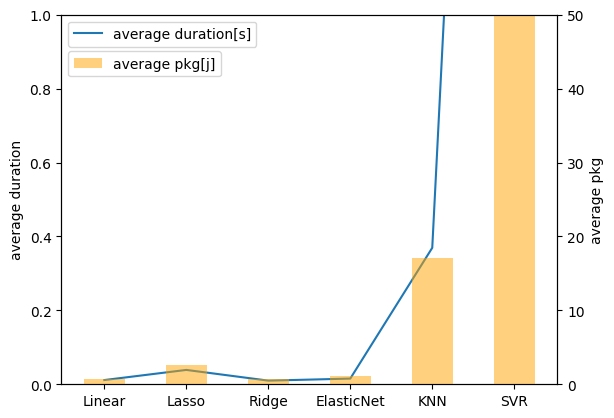

In [83]:
x_label = ['Linear', 'Lasso', 'Ridge', 'ElasticNet', 'KNN', 'SVR']
average_duration = [duration_linear, duration_lasso, duration_ridge, duration_elastic,
                    duration_knn, duration_svr]
average_pkg = [pkg_linear, pkg_lasso , pkg_ridge ,pkg_elastic,
               pkg_knn, pkg_svr]


# Create figure and axis #1
fig, ax1 = plt.subplots()# plot line chart on axis #1
ax1.plot(x_label, average_duration) 
ax1.set_ylabel('average duration')
ax1.set_ylim(0, 1)
ax1.legend(['average duration[s]'], loc="upper left")# set up the 2nd axis
ax2 = ax1.twinx()# plot bar chart on axis #2
ax2.bar(x_label, average_pkg, width=0.5, alpha=0.5, color='orange')
ax2.grid(False) # turn off grid #2
ax2.set_ylabel('average pkg')
ax2.set_ylim(0, 50)
ax2.legend(['average pkg[j]'], loc='upper left', bbox_to_anchor=(0, 0.92))

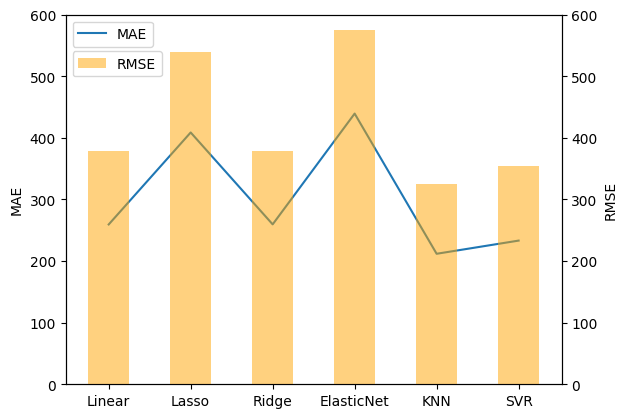

In [84]:
x_label = ['Linear', 'Lasso', 'Ridge', 'ElasticNet', 'KNN', 'SVR']
MAE = [mae_linear, mae_lasso, mae_ridge, mae_elastic,
                    mae_knn, mae_svr]
RMSE = [rmse_linear, rmse_lasso , rmse_ridge ,rmse_elastic,
               rmse_knn, rmse_svr]


# Create figure and axis #1
fig, ax1 = plt.subplots()# plot line chart on axis #1
ax1.plot(x_label, MAE) 
ax1.set_ylabel('MAE')
ax1.set_ylim(0, 600)
ax1.legend(['MAE'], loc="upper left")# set up the 2nd axis
ax2 = ax1.twinx()# plot bar chart on axis #2
ax2.bar(x_label, RMSE, width=0.5, alpha=0.5, color='orange')
ax2.grid(False) # turn off grid #2
ax2.set_ylabel('RMSE')
ax2.set_ylim(0, 600)
ax2.legend(['RMSE'], loc='upper left', bbox_to_anchor=(0, 0.92))

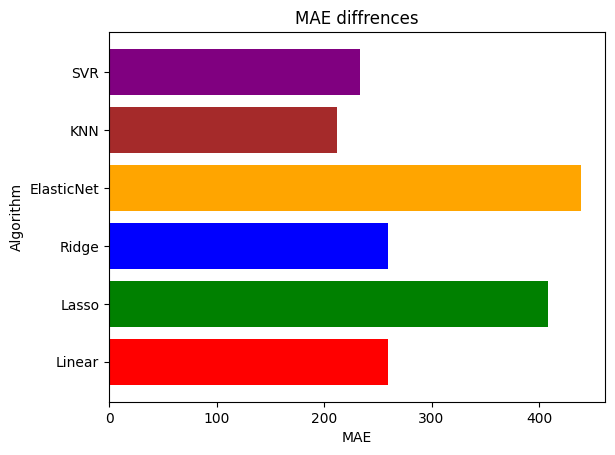

In [85]:
labels = (["Linear", "Lasso", "Ridge", "ElasticNet", "KNN", "SVR"])
mae_avr = ([mae_linear, mae_lasso, mae_ridge, mae_elastic, mae_knn, mae_svr])
plt.barh(labels, mae_avr, color = ['red', 'green','blue', 'orange', 'brown', 'purple'])

plt.xlabel('MAE')
plt.ylabel('Algorithm')
plt.title('MAE diffrences')
plt.show()
#stavi pokazatelj da se vidi koja boja je sto pa da ne moras stavljati imena na grafu
#plus na x stavi vrijeme na y satvi sta ti treba

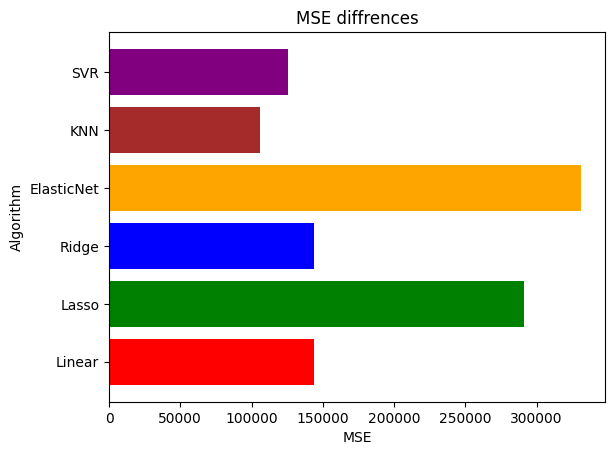

In [86]:
labels = (["Linear", "Lasso", "Ridge", "ElasticNet", "KNN", "SVR"])
mse_avr = ([mse_linear, mse_lasso, mse_ridge, mse_elastic, mse_knn, mse_svr])
plt.barh(labels, mse_avr, color = ['red', 'green','blue', 'orange', 'brown', 'purple'])

plt.xlabel('MSE')
plt.ylabel('Algorithm')
plt.title('MSE diffrences')
plt.show()


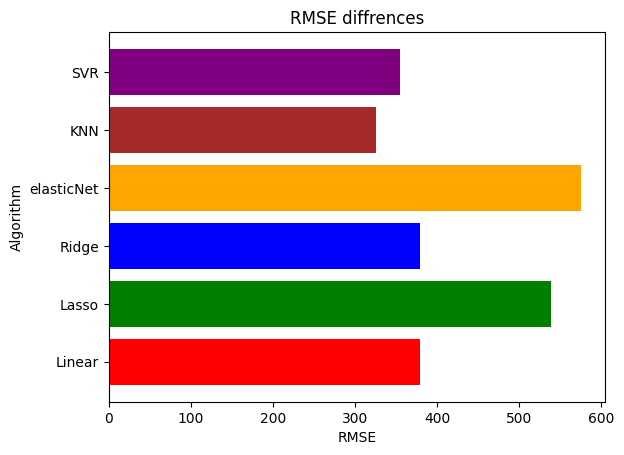

In [87]:
labels = (["Linear", "Lasso", "Ridge", "elasticNet", "KNN", "SVR"])
rmse_avr = ([rmse_linear, rmse_lasso, rmse_ridge, rmse_elastic, rmse_knn, rmse_svr])
plt.barh(labels, rmse_avr, color = ['red', 'green','blue', 'orange', 'brown', 'purple'])

plt.xlabel('RMSE')
plt.ylabel('Algorithm')
plt.title('RMSE diffrences')
plt.show()


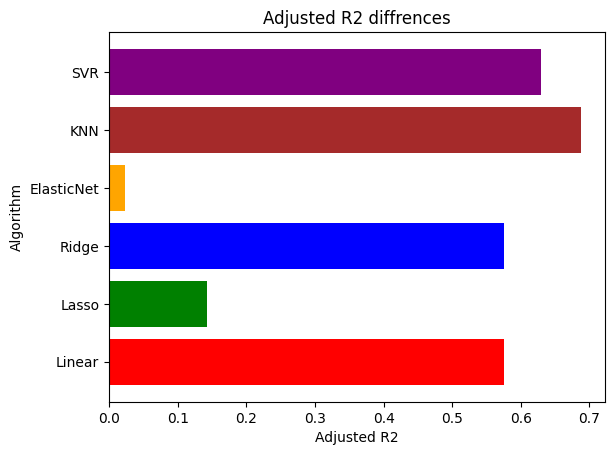

In [88]:
labels = (["Linear", "Lasso", "Ridge", "ElasticNet", "KNN", "SVR"])
adj_r2_avr = ([adj_r2_linear, adj_r2_lasso, adj_r2_ridge, adj_r2_elastic, 
               adj_r2_knn, adj_r2_svr])
plt.barh(labels, adj_r2_avr, color = ['red', 'green','blue', 'orange', 'brown', 'purple'])

plt.xlabel('Adjusted R2')
plt.ylabel('Algorithm')
plt.title('Adjusted R2 diffrences')
plt.show()

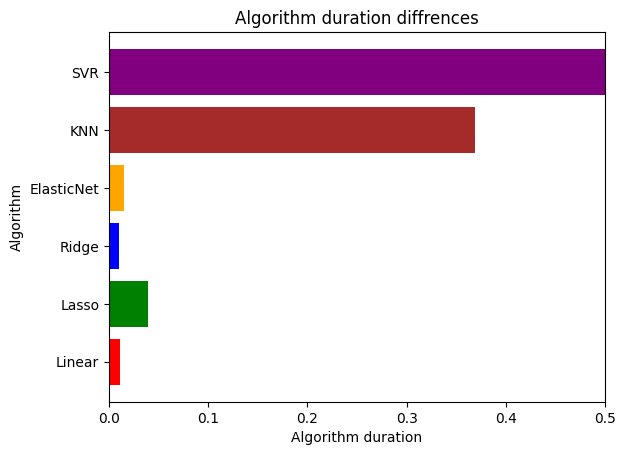

In [89]:
duration_avr = ([duration_linear, duration_lasso, duration_ridge, duration_elastic, 
                 duration_knn, duration_svr])

labels = (["Linear", "Lasso", "Ridge", "ElasticNet" ,"KNN", "SVR"])

plt.barh(labels, duration_avr, color = ['red', 'green','blue', 'orange', 'brown', 'purple'])

plt.xlabel('Algorithm duration')
plt.xlim(0, 0.5)
plt.ylabel('Algorithm')
plt.title('Algorithm duration diffrences')
plt.show()

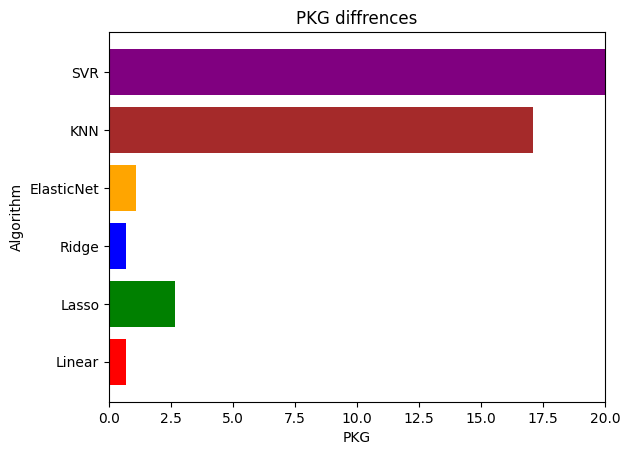

In [90]:
pkg = [pkg_linear, pkg_lasso , pkg_ridge ,pkg_elastic, pkg_knn, pkg_svr]

labels = (["Linear", "Lasso", "Ridge", "ElasticNet" ,"KNN", "SVR"])

plt.barh(labels, pkg, color = ['red', 'green','blue', 'orange', 'brown', 'purple'])

plt.xlabel('PKG')
plt.xlim(0, 20)
plt.ylabel('Algorithm')
plt.title('PKG diffrences')
plt.show()

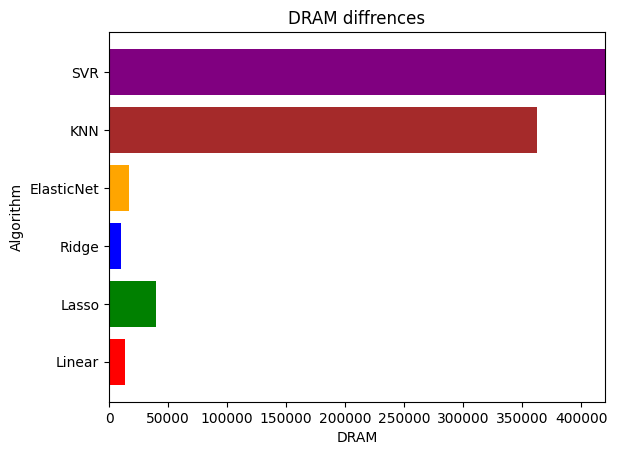

In [91]:
dram_avr = ([dram_linear, dram_lasso, dram_ridge, dram_elastic, dram_knn, dram_svr])

labels = (["Linear", "Lasso", "Ridge", "ElasticNet" ,"KNN", "SVR"])

plt.barh(labels, dram_avr, color = ['red', 'green','blue', 'orange', 'brown', 'purple'])

plt.xlabel('DRAM')
plt.xlim(0, 420000)
plt.ylabel('Algorithm')
plt.title('DRAM diffrences')
plt.show()